In [2]:
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img
import matplotlib.pyplot as plt
import matplotlib as mpl
import pathlib
import shutil
import numpy as np
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight 
import pandas as pd

In [3]:
def plot_categories(training_images, training_labels,mapping = None, count = 10):
  fig, axes = plt.subplots(int(np.sqrt(count))+1, int(np.sqrt(count))+1, figsize=(16, 15))
  axes = axes.flatten()
    
  for ax in axes:
    ax.set_axis_off()

  for k in range(count):
    img = training_images[k]
    img = array_to_img(img)
    ax = axes[k]
    ax.set_axis_on()
    ax.imshow(img, cmap="Greys_r")
    label = None
    if mapping:
        label = mapping[training_labels[k]]
    else:
        label = training_labels[k]
        
    ax.set_title(label)
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

In [4]:

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();
    
    
    
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Non-tumor detected (True Negatives): ', cm[0][0])
  print('Non-tumor incorrectly detected (False Positives): ', cm[0][1])
  print('Tumor missed (False Negatives): ', cm[1][0])
  print('Tumor detected (True Positives): ', cm[1][1])
  print('Total case: ', np.sum(cm[1]))

In [5]:
data_path = pathlib.Path("figshare-dataset/")
data_path = os.path.join(data_path, os.listdir(data_path)[0])

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=10,
                                     width_shift_range=0.05,
                                     height_shift_range=0.05,
                                     zoom_range=0.05,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     brightness_range = [0.5, 1.4],
                                     validation_split=0.2)

train_generator = train_datagen.flow_from_directory(directory=data_path,
                                                    batch_size=10,
                                                    target_size=(224, 224),
                                                    shuffle = True,
                                                    class_mode = "binary",
                                                    subset = "training")

validation_generator = train_datagen.flow_from_directory(directory=data_path,
                                                            batch_size=10,
                                                            target_size=(224, 224),
                                                            shuffle = False,
                                                            class_mode = "binary",
                                                            subset = "validation")

Found 204 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


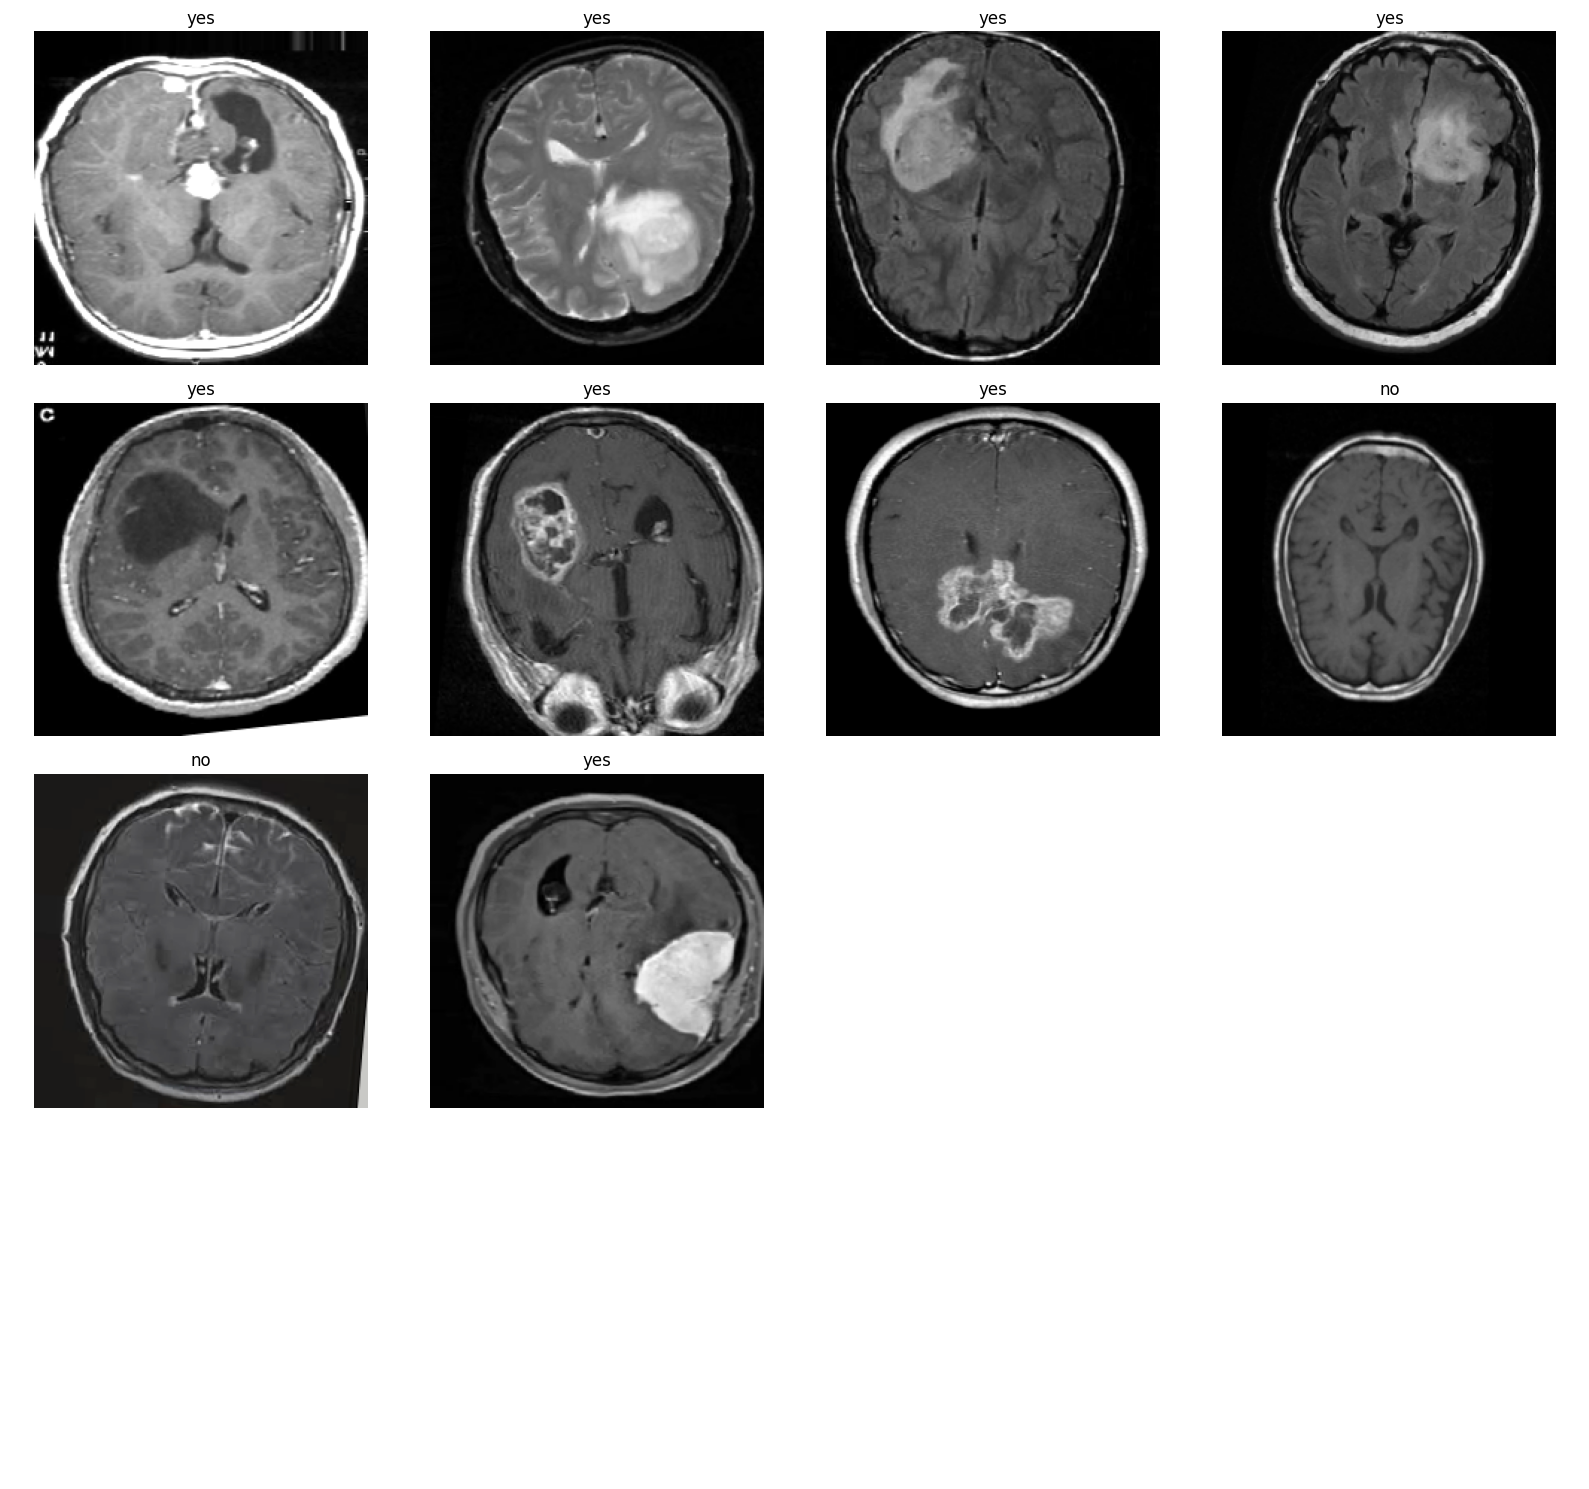

In [7]:
sample_X, sample_y = next(train_generator)
mapping = {1: "yes", 0: "no"}

plot_categories(sample_X, sample_y, mapping, sample_X.shape[0])


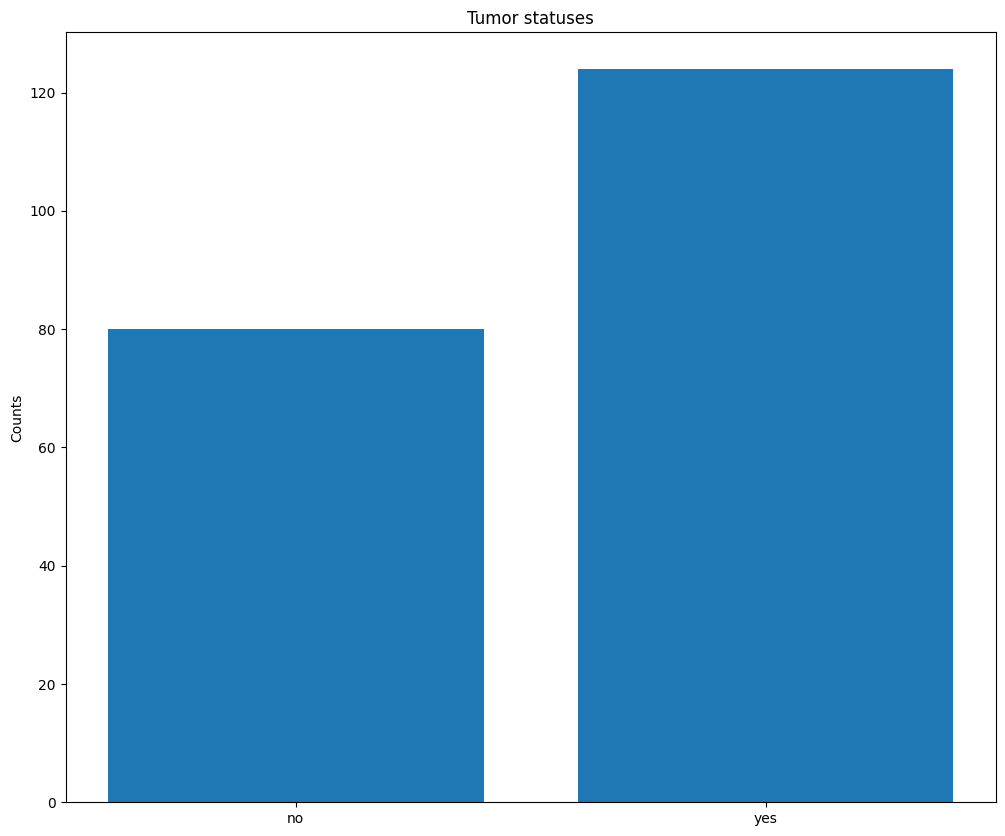

In [8]:
labels, counts = np.unique(train_generator.labels, return_counts = True)
labels = [mapping[l] for l in labels]

fig, ax = plt.subplots()
ax.set_ylabel('Counts')
ax.set_title('Tumor statuses')
ax.bar(labels, counts)

plt.show()

In [9]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
train_class_weights = dict(enumerate(class_weights))


In [10]:
metrics = [
    tf.keras.metrics.TruePositives(name='tp'),tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'),
]

# SIMPLE LENET CNN MODEL

In [11]:
model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(filters = 64 , kernel_size = (3,3), activation="relu", input_shape=(224,224,3)),
      tf.keras.layers.MaxPooling2D(pool_size = (3,3)),
      tf.keras.layers.Conv2D(filters = 32 , kernel_size = (3,3), activation="relu"),
      tf.keras.layers.MaxPooling2D(pool_size = (3,3)),
      tf.keras.layers.Conv2D(filters = 32 , kernel_size = (3,3), activation="relu"),
      tf.keras.layers.MaxPooling2D(pool_size = (3,3)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units = 512 , activation="relu"),
      tf.keras.layers.Dropout(rate = 0.5),
      tf.keras.layers.Dense(units = 1 , activation="sigmoid")
  ])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.0008),
                loss = "binary_crossentropy",
                metrics=metrics)

tf.keras.utils.plot_model(model) 
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 22, 22, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       803,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 833,345 (3.18 MB)

 Trainable params: 833,345 (3.18 MB)

 Non-trainable params: 0 (0.00 B)

## EPOCH SIZE EXPERIMENTATION

In [13]:
# EPOCH SIZE 10
history = model.fit(
    train_generator,
    epochs = 10, 
    validation_data = validation_generator, 
    class_weight=train_class_weights)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 273ms/step - accuracy: 0.4924 - auc: 0.4986 - fn: 49.3636 - fp: 6.1364 - loss: 0.7248 - prc: 0.5778 - precision: 0.5046 - recall: 0.1550 - tn: 41.5000 - tp: 14.5455 - val_accuracy: 0.7451 - val_auc: 0.8056 - val_fn: 3.0000 - val_fp: 10.0000 - val_loss: 0.5820 - val_prc: 0.8584 - val_precision: 0.7368 - val_recall: 0.9032 - val_tn: 10.0000 - val_tp: 28.0000
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.6917 - auc: 0.7331 - fn: 18.5909 - fp: 15.2727 - loss: 0.6056 - prc: 0.7362 - precision: 0.7373 - recall: 0.7317 - tn: 31.3636 - tp: 48.7727 - val_accuracy: 0.7451 - val_auc: 0.7613 - val_fn: 3.0000 - val_fp: 10.0000 - val_loss: 0.5490 - val_prc: 0.7930 - val_precision: 0.7368 - val_recall: 0.9032 - val_tn: 10.0000 - val_tp: 28.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.7215 - auc: 0.7806 - fn: 7.5909 - fp: 20.9545 - loss: 0.5955 - prc: 0.8408 - precision: 0.7378 - recall: 0.8757 - tn: 20.0455 - tp: 5

In [14]:
validation_results0 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results0):
    print(f"[10 Epochs] {name} : {value}")

[10 Epochs] loss : 0.5434969663619995
[10 Epochs] compile_metrics : 26.0


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
Non-tumor detected (True Negatives):  13
Non-tumor incorrectly detected (False Positives):  7
Tumor missed (False Negatives):  4
Tumor detected (True Positives):  27
Total case:  31


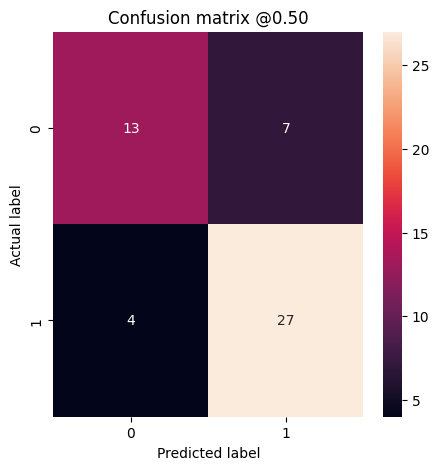

In [15]:
validation_predictions0 = model.predict(validation_generator)

labels = validation_generator.labels

plot_cm(labels, validation_predictions0)

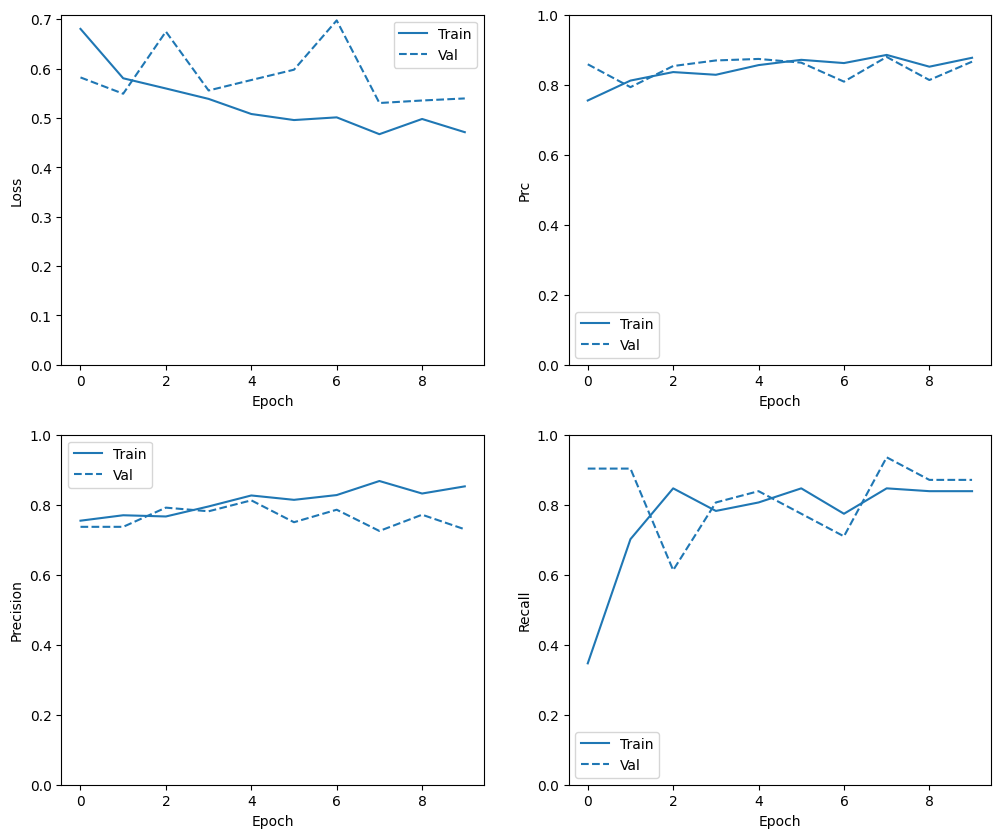

In [17]:
plot_metrics(history)

In [48]:
# EPOCH SIZE 20
history1 = model.fit(
    train_generator,epochs = 20, 
    validation_data = validation_generator, 
    class_weight=train_class_weights)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.9233 - auc: 0.9867 - fn: 4.4545 - fp: 3.0909 - loss: 0.1984 - prc: 0.9922 - precision: 0.9258 - recall: 0.9506 - tn: 41.2273 - tp: 63.3182 - val_accuracy: 0.8039 - val_auc: 0.9048 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.4694 - val_prc: 0.9023 - val_precision: 0.7838 - val_recall: 0.9355 - val_tn: 12.0000 - val_tp: 29.0000
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.9362 - auc: 0.9798 - fn: 4.8182 - fp: 2.7727 - loss: 0.2154 - prc: 0.9869 - precision: 0.9510 - recall: 0.9410 - tn: 41.7273 - tp: 60.8636 - val_accuracy: 0.8235 - val_auc: 0.8887 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.4467 - val_prc: 0.8917 - val_precision: 0.8235 - val_recall: 0.9032 - val_tn: 14.0000 - val_tp: 28.0000
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.9397 - auc: 0.9933 - fn: 4.7273 - fp: 1.9091 - loss: 0.1374 - prc: 0.9961 - precision: 0.9778 - recall: 0.9251 - tn: 40.9091 - tp: 65.0909 - val

In [49]:
validation_results1 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results1):
  print(name, ': ', value)

loss :  0.3842649757862091
compile_metrics :  29.0


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 813ms/step
Non-tumor detected (True Negatives):  15
Non-tumor incorrectly detected (False Positives):  5
Tumor missed (False Negatives):  2
Tumor detected (True Positives):  29
Total case:  31


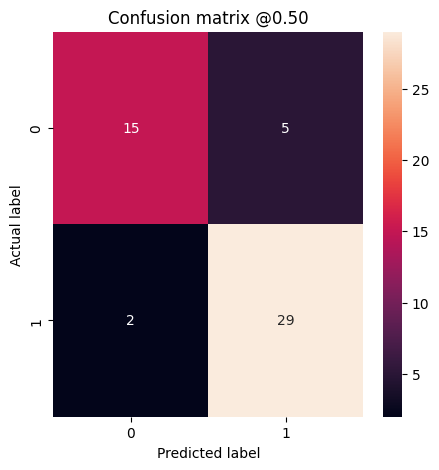

In [50]:
validation_predictions1 = model.predict(validation_generator)

labels = validation_generator.labels

plot_cm(labels, validation_predictions1)

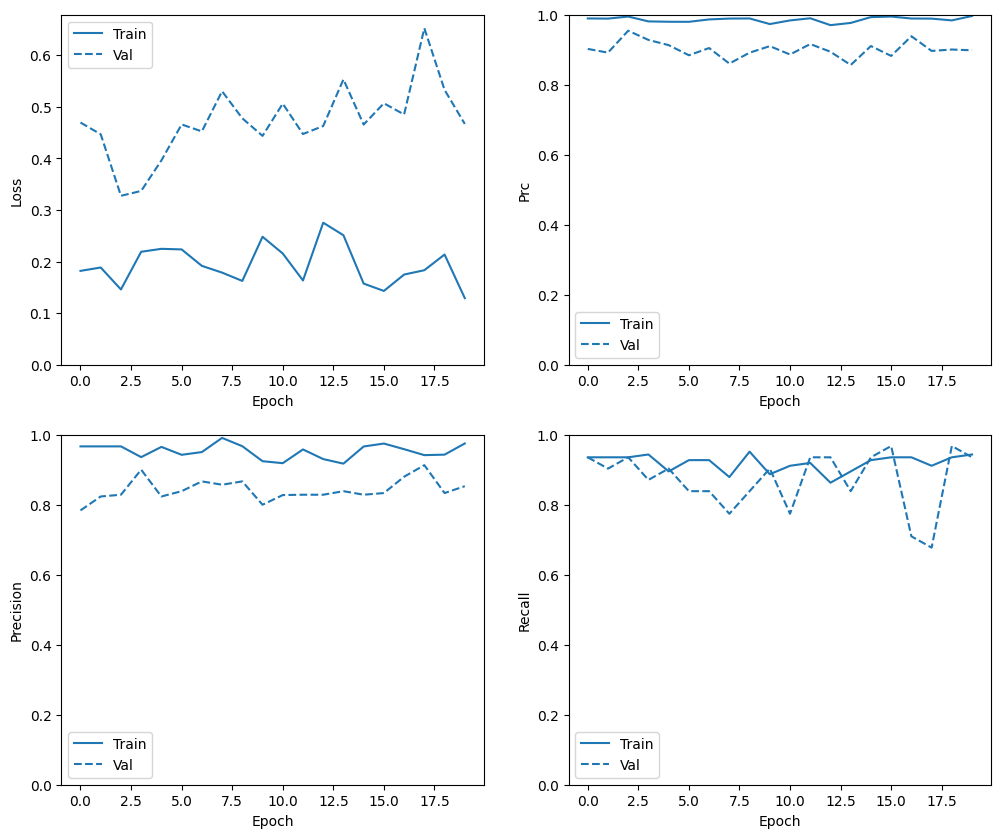

In [51]:
plot_metrics(history1)

In [18]:
# EPOCH SIZE 40
history11 = model.fit(
    train_generator,
    epochs=40,
    validation_data=validation_generator,
    class_weight=train_class_weights
)

Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - accuracy: 0.8204 - auc: 0.8815 - fn: 11.9091 - fp: 8.4091 - loss: 0.4580 - prc: 0.9089 - precision: 0.8595 - recall: 0.8335 - tn: 36.2273 - tp: 53.0909 - val_accuracy: 0.7451 - val_auc: 0.7944 - val_fn: 3.0000 - val_fp: 10.0000 - val_loss: 0.5349 - val_prc: 0.8372 - val_precision: 0.7368 - val_recall: 0.9032 - val_tn: 10.0000 - val_tp: 28.0000
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.8117 - auc: 0.8913 - fn: 8.2273 - fp: 13.1818 - loss: 0.4233 - prc: 0.9083 - precision: 0.8097 - recall: 0.9000 - tn: 31.1364 - tp: 60.0909 - val_accuracy: 0.7255 - val_auc: 0.8000 - val_fn: 4.0000 - val_fp: 10.0000 - val_loss: 0.6065 - val_prc: 0.8494 - val_precision: 0.7297 - val_recall: 0.8710 - val_tn: 10.0000 - val_tp: 27.0000
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - accuracy: 0.8127 - auc: 0.9121 - fn: 11.2273 - fp: 9.3636 - loss: 0.3878 - prc: 0.9409 - precision: 0.8448 - recall: 0.8405 - tn: 35.9091 - tp: 54

In [19]:
validation_results11 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results11):
    print(f"[40 Epochs] {name} : {value}")

[40 Epochs] loss : 0.552793025970459
[40 Epochs] compile_metrics : 28.0


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
Non-tumor detected (True Negatives):  11
Non-tumor incorrectly detected (False Positives):  9
Tumor missed (False Negatives):  2
Tumor detected (True Positives):  29
Total case:  31


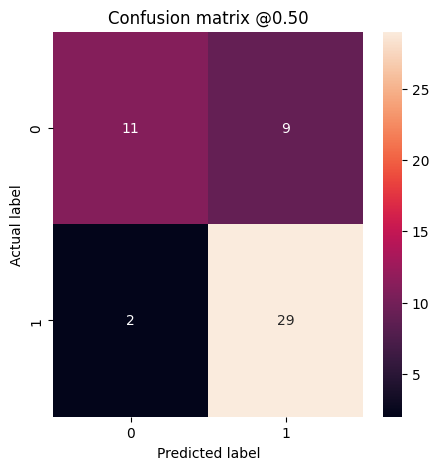

In [20]:
validation_predictions11 = model.predict(validation_generator)

labels = validation_generator.labels

plot_cm(labels, validation_predictions11)

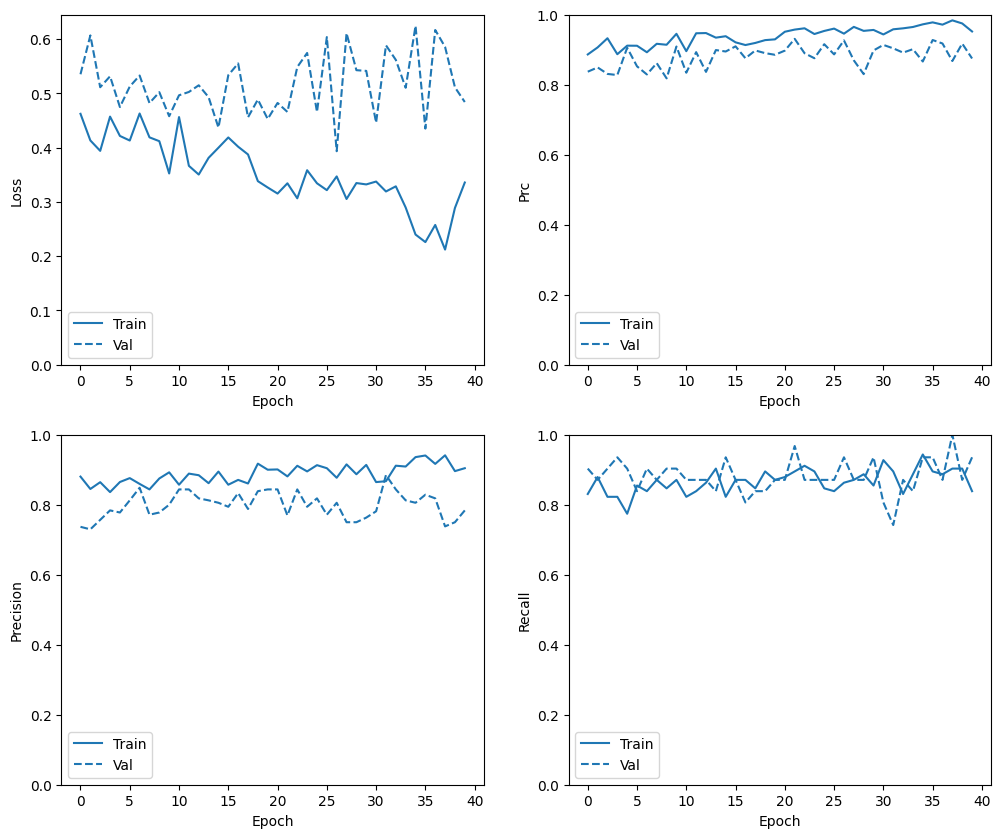

In [21]:
plot_metrics(history11)

# RESNETV2 MODEL

In [13]:
base_model = tf.keras.applications.InceptionResNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
                              base_model,
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(128, activation = 'relu'),
                              tf.keras.layers.Dropout(rate = 0.2),
                              tf.keras.layers.Dense(1, activation='sigmoid')
                            ])

model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.0001),
                loss = "binary_crossentropy",
                metrics=metrics)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 5, 5, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,915,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,252,193 (226.03 MB)

 Trainable params: 4,915,457 (18.75 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

## EPOCH SIZE EXPERIMENTATION

In [44]:
# EPOCH SIZE 10
history3 = model.fit(
    train_generator,epochs = 10, 
    validation_data = validation_generator, 
    class_weight=train_class_weights)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.8878 - auc: 0.9626 - fn: 6.5455 - fp: 5.3636 - loss: 0.2457 - prc: 0.9733 - precision: 0.9161 - recall: 0.8893 - tn: 38.0909 - tp: 58.8182 - val_accuracy: 0.8039 - val_auc: 0.8976 - val_fn: 6.0000 - val_fp: 4.0000 - val_loss: 0.4378 - val_prc: 0.9238 - val_precision: 0.8621 - val_recall: 0.8065 - val_tn: 16.0000 - val_tp: 25.0000
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.8872 - auc: 0.9633 - fn: 8.7273 - fp: 3.5455 - loss: 0.2705 - prc: 0.9798 - precision: 0.9597 - recall: 0.8602 - tn: 38.2273 - tp: 61.0455 - val_accuracy: 0.8824 - val_auc: 0.9024 - val_fn: 4.0000 - val_fp: 2.0000 - val_loss: 0.4312 - val_prc: 0.9015 - val_precision: 0.9310 - val_recall: 0.8710 - val_tn: 18.0000 - val_tp: 27.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.8699 - auc: 0.9715 - fn: 8.5000 - fp: 3.7727 - loss: 0.2470 - prc: 0.9786 - precision: 0.9328 - recall: 0.8229 - tn: 41.5909 - tp: 55.5000 - val

In [45]:
validation_results3 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results3):
  print(name, ': ', value)

loss :  0.4576760232448578
compile_metrics :  31.0


6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Non-tumor detected (True Negatives):  12
Non-tumor incorrectly detected (False Positives):  8
Tumor missed (False Negatives):  0
Tumor detected (True Positives):  31
Total case:  31


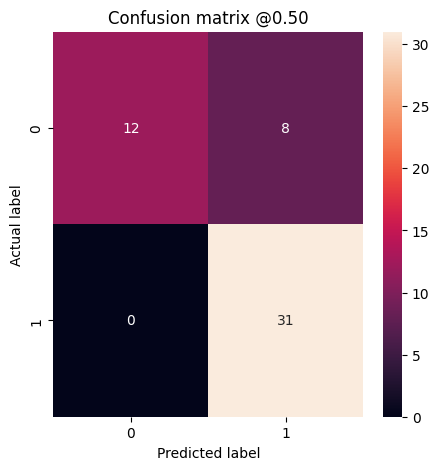

In [46]:
validation_predictions3 = model.predict(validation_generator)

labels = validation_generator.classes

plot_cm(labels, validation_predictions3)

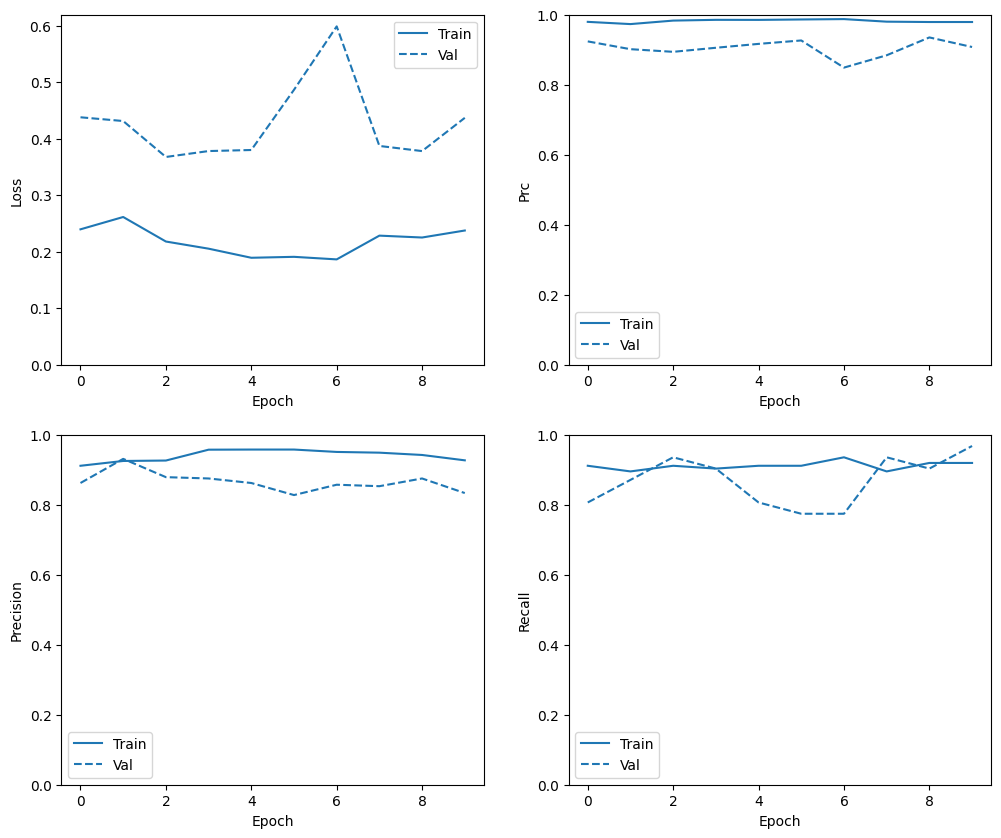

In [47]:
plot_metrics(history3)

In [22]:
# EPOCH SIZE 20
history33 = model.fit(
    train_generator,epochs = 20, 
    validation_data = validation_generator, 
    class_weight=train_class_weights)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - accuracy: 0.9250 - auc: 0.9656 - fn: 4.0455 - fp: 6.2273 - loss: 0.2247 - prc: 0.9754 - precision: 0.9313 - recall: 0.9524 - tn: 34.8636 - tp: 65.3182 - val_accuracy: 0.7843 - val_auc: 0.8169 - val_fn: 3.0000 - val_fp: 8.0000 - val_loss: 0.5986 - val_prc: 0.8829 - val_precision: 0.7778 - val_recall: 0.9032 - val_tn: 12.0000 - val_tp: 28.0000
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step - accuracy: 0.8206 - auc: 0.9566 - fn: 8.0000 - fp: 8.7273 - loss: 0.2856 - prc: 0.9731 - precision: 0.8772 - recall: 0.8403 - tn: 36.0000 - tp: 59.6364 - val_accuracy: 0.8039 - val_auc: 0.8702 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.4983 - val_prc: 0.9163 - val_precision: 0.7838 - val_recall: 0.9355 - val_tn: 12.0000 - val_tp: 29.0000
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - accuracy: 0.9420 - auc: 0.9713 - fn: 1.7273 - fp: 6.2273 - loss: 0.2199 - prc: 0.9771 - precision: 0.9266 - recall: 0.9829 - tn: 37.4545 - tp: 65.0455

In [23]:
validation_results33 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results33):
  print(name, ': ', value)

loss :  0.6001714468002319
compile_metrics :  23.0


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
Non-tumor detected (True Negatives):  17
Non-tumor incorrectly detected (False Positives):  3
Tumor missed (False Negatives):  7
Tumor detected (True Positives):  24
Total case:  31


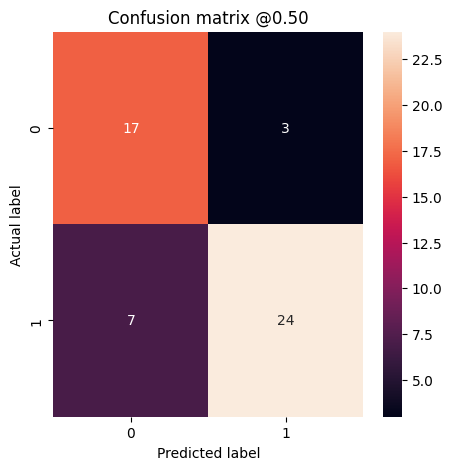

In [24]:
validation_predictions33 = model.predict(validation_generator)

labels = validation_generator.classes

plot_cm(labels, validation_predictions33)

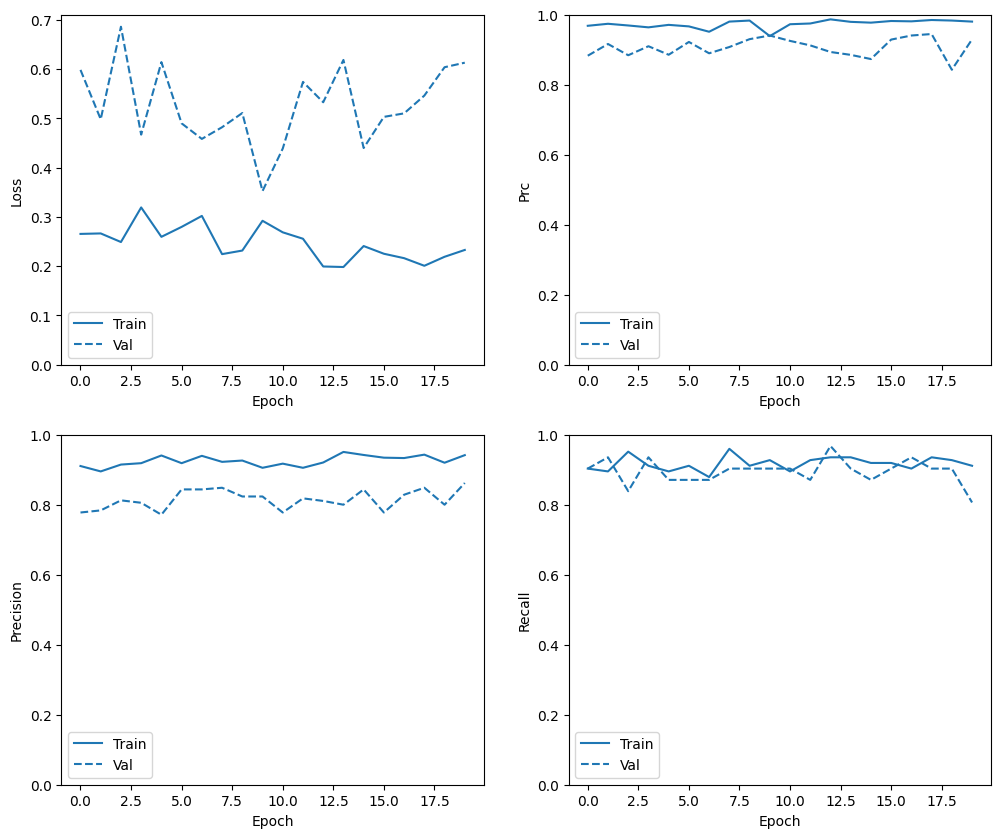

In [25]:
plot_metrics(history33)

In [26]:
# EPOCH SIZE 40
history333 = model.fit(
    train_generator,epochs = 40, 
    validation_data = validation_generator, 
    class_weight=train_class_weights)

Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - accuracy: 0.8784 - auc: 0.9465 - fn: 8.3636 - fp: 4.0000 - loss: 0.3673 - prc: 0.9571 - precision: 0.9456 - recall: 0.8460 - tn: 42.0455 - tp: 59.5909 - val_accuracy: 0.8039 - val_auc: 0.9065 - val_fn: 3.0000 - val_fp: 7.0000 - val_loss: 0.4006 - val_prc: 0.9355 - val_precision: 0.8000 - val_recall: 0.9032 - val_tn: 13.0000 - val_tp: 28.0000
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - accuracy: 0.9396 - auc: 0.9877 - fn: 2.1818 - fp: 4.6364 - loss: 0.1741 - prc: 0.9920 - precision: 0.9282 - recall: 0.9699 - tn: 37.7273 - tp: 64.2727 - val_accuracy: 0.8627 - val_auc: 0.8532 - val_fn: 3.0000 - val_fp: 4.0000 - val_loss: 0.5943 - val_prc: 0.8926 - val_precision: 0.8750 - val_recall: 0.9032 - val_tn: 16.0000 - val_tp: 28.0000
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step - accuracy: 0.8691 - auc: 0.9732 - fn: 10.2727 - fp: 3.8182 - loss: 0.2157 - prc: 0.9785 - precision: 0.9470 - recall: 0.8151 - tn: 41.3636 - tp: 54.181

In [27]:
validation_results333 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results333):
  print(name, ': ', value)

loss :  0.4667320251464844
compile_metrics :  29.0


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
Non-tumor detected (True Negatives):  15
Non-tumor incorrectly detected (False Positives):  5
Tumor missed (False Negatives):  1
Tumor detected (True Positives):  30
Total case:  31


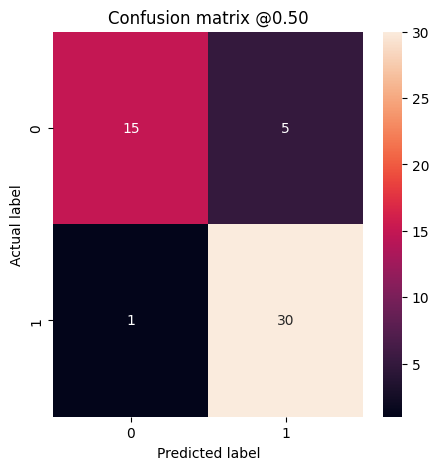

In [28]:
validation_predictions333 = model.predict(validation_generator)

labels = validation_generator.classes

plot_cm(labels, validation_predictions333)

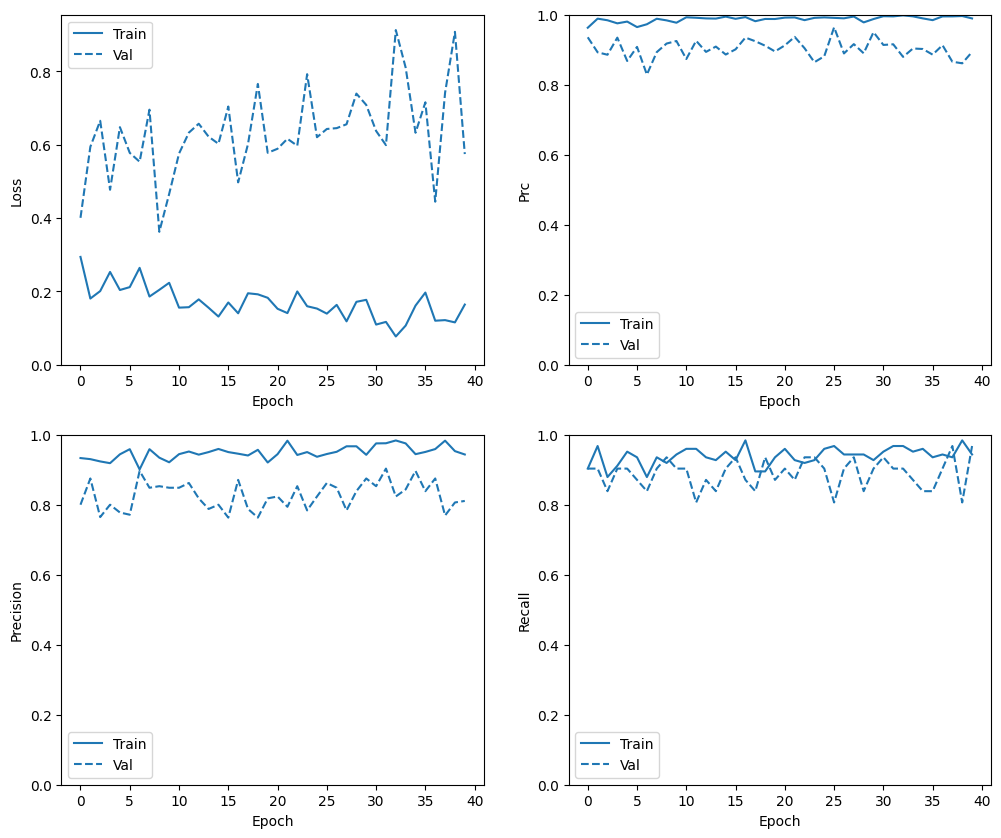

In [29]:
plot_metrics(history333)

# VGG16 MODEL

In [30]:
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
                              base_model,
                              tf.keras.layers.GlobalMaxPooling2D(),
                              tf.keras.layers.Dense(4096, activation = 'relu'),
                              tf.keras.layers.Dropout(rate=0.5),
                              tf.keras.layers.Dense(1, activation='sigmoid')
                            ])

model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.0001),
                loss = "binary_crossentropy",
                metrics=metrics)

## EPOCH SIZE EXPERIMENTATION

In [31]:
# EPOCH SIZE 10
history44 = model.fit(
    train_generator,epochs = 10, 
    validation_data = validation_generator, 
    class_weight=train_class_weights)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.6788 - auc: 0.7517 - fn: 26.0455 - fp: 28.5455 - loss: 0.6875 - prc: 0.8280 - precision: 0.7307 - recall: 0.7554 - tn: 33.4091 - tp: 72.0909 - val_accuracy: 0.7647 - val_auc: 0.8218 - val_fn: 0.0000e+00 - val_fp: 12.0000 - val_loss: 0.5675 - val_prc: 0.8866 - val_precision: 0.7209 - val_recall: 1.0000 - val_tn: 8.0000 - val_tp: 31.0000
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.7067 - auc: 0.7992 - fn: 10.9545 - fp: 19.4091 - loss: 0.5810 - prc: 0.8564 - precision: 0.7266 - recall: 0.8631 - tn: 22.8636 - tp: 55.5909 - val_accuracy: 0.7647 - val_auc: 0.8379 - val_fn: 4.0000 - val_fp: 8.0000 - val_loss: 0.5114 - val_prc: 0.8566 - val_precision: 0.7714 - val_recall: 0.8710 - val_tn: 12.0000 - val_tp: 27.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.7282 - auc: 0.7981 - fn: 16.0000 - fp: 14.0000 - loss: 0.5429 - prc: 0.8450 - precision: 0.7951 - recall: 0.7762 - tn: 29.5909 - tp: 54.

In [32]:
validation_results44 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results44):
  print(name, ': ', value)

loss :  0.4506303369998932
compile_metrics :  28.0


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
Non-tumor detected (True Negatives):  13
Non-tumor incorrectly detected (False Positives):  7
Tumor missed (False Negatives):  4
Tumor detected (True Positives):  27
Total case:  31


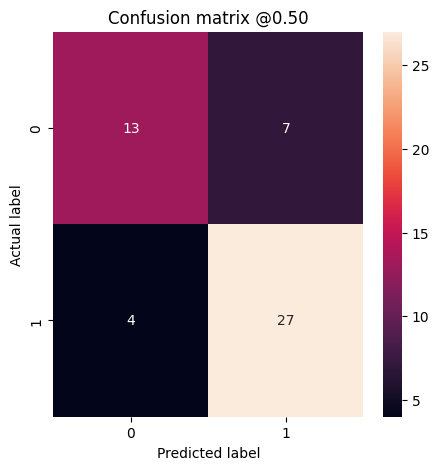

In [33]:
validation_predictions44 = model.predict(validation_generator)

labels = validation_generator.classes

plot_cm(labels, validation_predictions44)

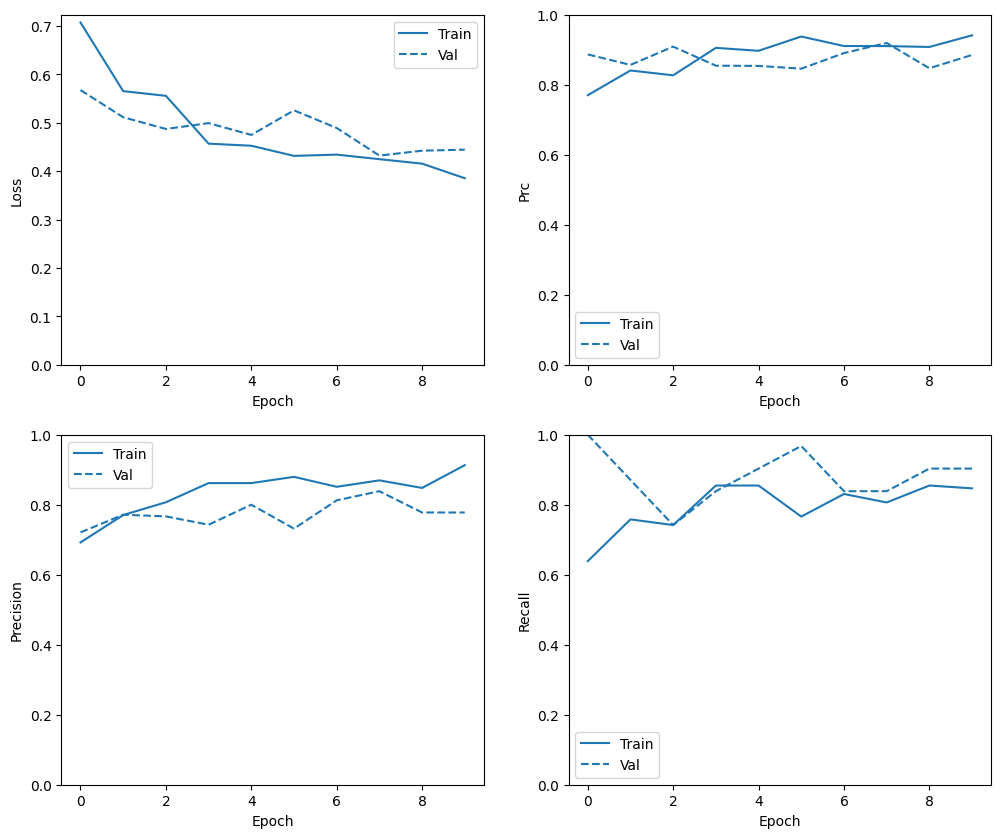

In [34]:
plot_metrics(history44)

In [40]:
# EPOCH SIZE 20
history4 = model.fit(
    train_generator,epochs = 20, 
    validation_data = validation_generator, 
    class_weight=train_class_weights)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.8820 - auc: 0.9622 - fn: 7.4091 - fp: 4.6818 - loss: 0.2647 - prc: 0.9738 - precision: 0.9178 - recall: 0.8910 - tn: 37.2273 - tp: 61.6818 - val_accuracy: 0.8039 - val_auc: 0.8782 - val_fn: 7.0000 - val_fp: 3.0000 - val_loss: 0.4800 - val_prc: 0.8799 - val_precision: 0.8889 - val_recall: 0.7742 - val_tn: 17.0000 - val_tp: 24.0000
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.9131 - auc: 0.9701 - fn: 5.5455 - fp: 2.9545 - loss: 0.2367 - prc: 0.9838 - precision: 0.9615 - recall: 0.9066 - tn: 35.8182 - tp: 64.7727 - val_accuracy: 0.7451 - val_auc: 0.8871 - val_fn: 9.0000 - val_fp: 4.0000 - val_loss: 0.4623 - val_prc: 0.9174 - val_precision: 0.8462 - val_recall: 0.7097 - val_tn: 16.0000 - val_tp: 22.0000
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.8882 - auc: 0.9735 - fn: 8.6818 - fp: 2.8636 - loss: 0.2428 - prc: 0.9768 - precision: 0.9512 - recall: 0.8417 - tn: 44.4091 - tp: 57.5000 - val

In [41]:
validation_results4 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results4):
  print(name, ': ', value)

loss :  0.5123209357261658
compile_metrics :  26.0


6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
Non-tumor detected (True Negatives):  16
Non-tumor incorrectly detected (False Positives):  4
Tumor missed (False Negatives):  2
Tumor detected (True Positives):  29
Total case:  31


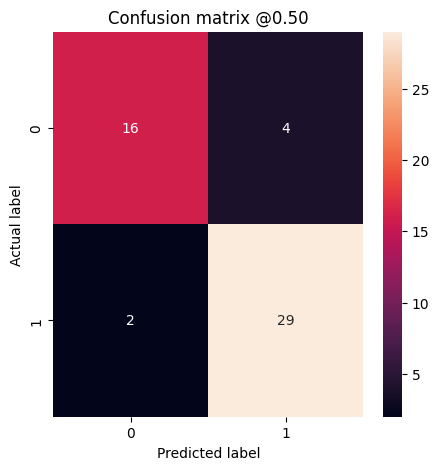

In [42]:
validation_predictions4 = model.predict(validation_generator)

labels = validation_generator.classes

plot_cm(labels, validation_predictions4)

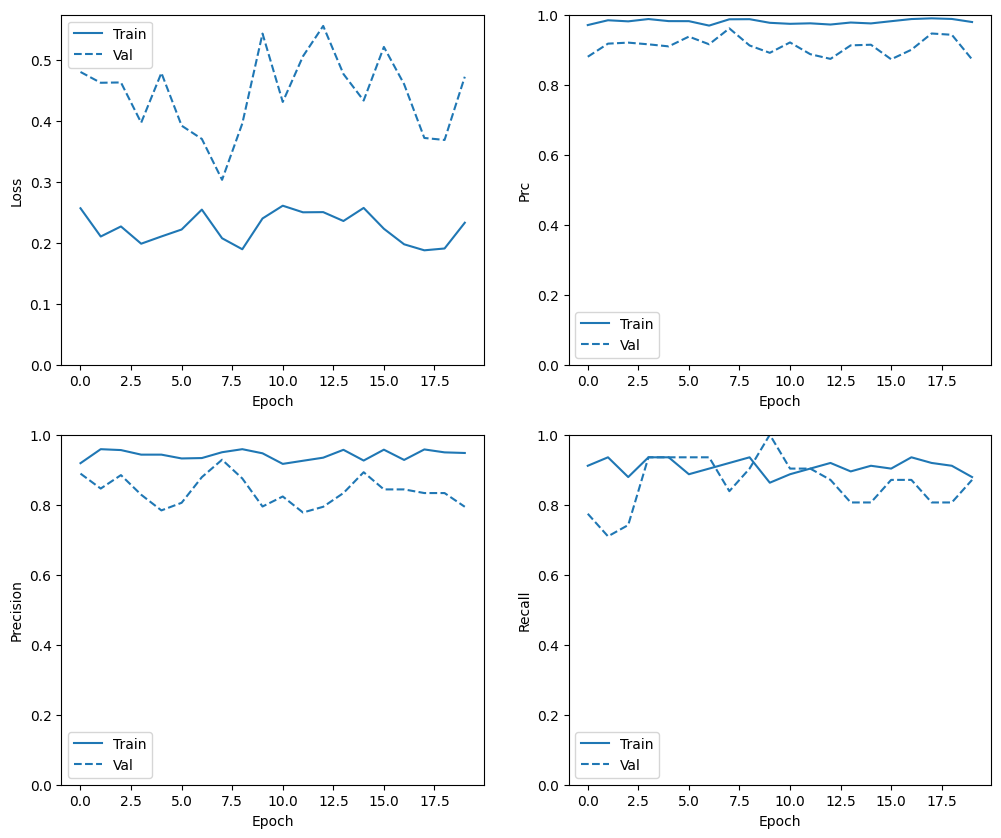

In [43]:
plot_metrics(history4)

In [36]:
# EPOCH SIZE 40
history444 = model.fit(
    train_generator,epochs = 40, 
    validation_data = validation_generator, 
    class_weight=train_class_weights)

Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.8808 - auc: 0.9461 - fn: 9.4545 - fp: 4.4545 - loss: 0.3248 - prc: 0.9630 - precision: 0.9421 - recall: 0.8557 - tn: 39.0455 - tp: 57.5000 - val_accuracy: 0.7647 - val_auc: 0.8581 - val_fn: 6.0000 - val_fp: 6.0000 - val_loss: 0.4513 - val_prc: 0.8864 - val_precision: 0.8065 - val_recall: 0.8065 - val_tn: 14.0000 - val_tp: 25.0000
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.8512 - auc: 0.9606 - fn: 11.2727 - fp: 5.6818 - loss: 0.3061 - prc: 0.9696 - precision: 0.9029 - recall: 0.8445 - tn: 38.1818 - tp: 56.1364 - val_accuracy: 0.8235 - val_auc: 0.8702 - val_fn: 5.0000 - val_fp: 4.0000 - val_loss: 0.4406 - val_prc: 0.8809 - val_precision: 0.8667 - val_recall: 0.8387 - val_tn: 16.0000 - val_tp: 26.0000
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.8499 - auc: 0.9340 - fn: 12.0909 - fp: 6.5000 - loss: 0.3328 - prc: 0.9530 - precision: 0.9263 - recall: 0.8241 - tn: 36.1818 - tp: 55.1364 - v

In [37]:
validation_results444 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results444):
  print(name, ': ', value)

loss :  0.4008743464946747
compile_metrics :  28.0


6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
Non-tumor detected (True Negatives):  14
Non-tumor incorrectly detected (False Positives):  6
Tumor missed (False Negatives):  2
Tumor detected (True Positives):  29
Total case:  31


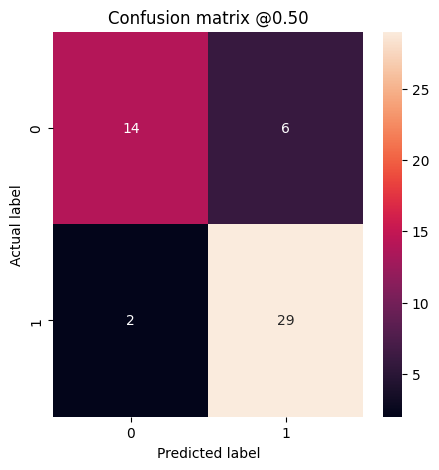

In [38]:
validation_predictions444 = model.predict(validation_generator)

labels = validation_generator.classes

plot_cm(labels, validation_predictions444)

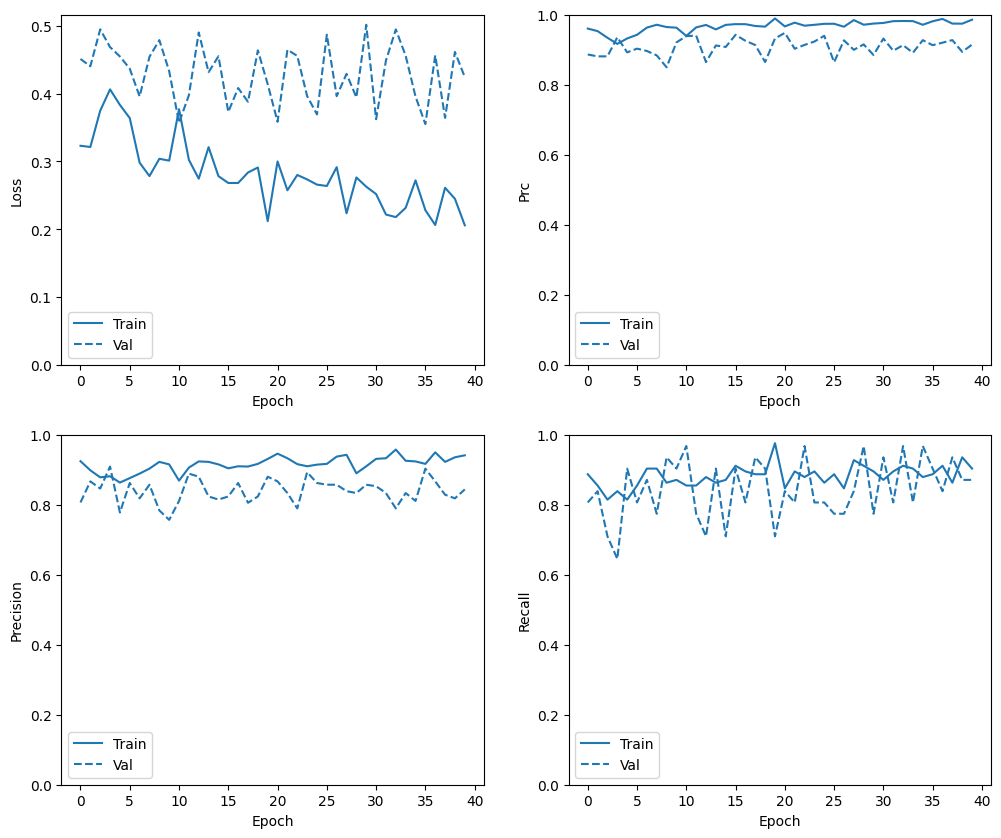

In [39]:
plot_metrics(history444)

# OVERALL RESULTS

In [53]:
res = [["Simple CNN [10 Epoch]", ],
       ["Simple CNN [20 Epoch]", ],
       ["Simple CNN [40 Epoch]", ],
       ["ResNetV2 [10 Epoch]", ],
       ["ResNetV2 [20 Epoch]", ],
       ["ResNetV2 [40 Epoch]", ],
       ["VGG16 [10 Epoch]", ],
       ["VGG16 [20 Epoch]", ], 
       ["VGG16 [40 Epoch]", ]]
histories = [history,history1,history11,history3,history33,history333,history44,history4,history444]

for i,hist in enumerate(histories):
    
    hist_li = list(hist.history.values())
    
    acc = hist_li[15][0]
    precision = hist_li[16][0]
    recall = hist_li[17][0]
    max_auc = hist_li[18][0]
    
    mean_acc = np.mean(hist_li[15])
    mean_precision = np.mean(hist_li[16])
    mean_recall = np.mean(hist_li[17])
    mean_auc = np.mean(hist_li[18])
    
    
    for j in range(len(hist_li[16])):
        if hist_li[18][j] > max_auc: # finding epoch with maximum AUC achieved
            
            acc = hist_li[15][j]
            precision = hist_li[16][j]
            recall = hist_li[17][j]
            max_auc = hist_li[18][j]
        
    
    res[i] += [precision,recall, max_auc, acc,mean_precision, mean_recall,mean_auc,mean_acc]
    
df = pd.DataFrame(res, columns = ["Model Name", f"Precision (with Max AUC)","Recall (with Max AUC)"," Max AUC", "Accuracy",
                                 "Mean Precision", "Mean Recall","Mean AUC", "Mean Accuracy"])

df

,Model Name,Precision (with Max AUC),Recall (with Max AUC),Max AUC,Accuracy,Mean Precision,Mean Recall,Mean AUC,Mean Accuracy
0,Simple CNN [10 Epoch],0.791667,0.612903,15.0,0.853401,0.762097,0.822581,11.900,0.847840
1,Simple CNN [20 Epoch],0.913043,0.677419,18.0,0.896564,0.842663,0.870968,14.850,0.901019
2,Simple CNN [40 Epoch],0.884615,0.741935,17.0,0.903932,0.799302,0.882258,13.025,0.881065
3,ResNetV2 [10 Epoch],0.931035,0.870968,18.0,0.901536,0.865496,0.867742,15.800,0.904398
4,ResNetV2 [20 Epoch],0.862069,0.806452,16.0,0.929647,0.815076,0.895161,13.650,0.907310
5,ResNetV2 [40 Epoch],0.896552,0.838710,17.0,0.828919,0.826537,0.888710,14.125,0.902144
6,VGG16 [10 Epoch],0.838710,0.838710,15.0,0.919318,0.774036,0.880645,11.900,0.874792
7,VGG16 [20 Epoch],0.928571,0.838710,18.0,0.960945,0.839235,0.861290,14.750,0.910113
8,VGG16 [40 Epoch],0.909091,0.645161,18.0,0.935544,0.839124,0.844355,14.850,0.908034
